In [1]:
from dragonn import models
from dragonn.plot import add_letters_to_axis

from sklearn.model_selection import train_test_split

from collections import OrderedDict
from pprint import pprint
from warnings import warn

import numpy as np
import matplotlib.pyplot as plt

import math

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [5]:
data_dir = '/mnt/data/'
model_dir = 'models/'
rebuild_data = True

if rebuild_data:
    
    key_to_seq = OrderedDict()
    seq_len = 145
    reg_len = 295
    skip_len = 5

    with open("../data/Scaleup_counts_sequences/ScaleUpDesign1.sequences.txt") as f:
        for line in f:
            key, seq = line.strip().split()

            # TODO: Figure out if this is an OK thing to do. 'N' basically means the 
            # sequencing software couldn't figure out what the base was...?
            if "N" in seq:
                seq = seq.replace("N", "A")

            assert key not in key_to_seq
            key_to_seq[key] = seq

    with open("../data/Scaleup_counts_sequences/ScaleUpDesign2.sequences.txt") as f:
        for line in f:
            key, seq = line.strip().split()

            if "N" in seq:
                seq = seq.replace("N", "A")

            assert key not in key_to_seq
            key_to_seq[key] = seq


In [6]:
if rebuild_data:
    split_data = {}
    data = {}
    sample_weights = {}
    cell_types =  ["HepG2", "K562"]
    promoters = ["SV40P", "minP"]
    design_names = ["ScaleUpDesign1", "ScaleUpDesign2"]

    for cell_type in cell_types:
        for promoter in promoters:
            experiment_key = (cell_type, promoter)
            data[experiment_key] = {}
            split_data[experiment_key] = {}
            sample_weights[experiment_key] = {}

            for design_name in design_names:

                with open("../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep1.normalized".format(cell_type, design_name, promoter)) as f:
                    for line in f:
                        parts = line.strip().split()

                        key = parts[0]
                        val = float(parts[1])
                        if parts[2] == "1":
                            data[experiment_key][key] = val
                            split_data[experiment_key][key] = (val, 0)

                with open("../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep2.normalized".format(cell_type, design_name, promoter)) as f:
                    for line in f:
                        parts = line.strip().split()

                        key = parts[0]
                        val = float(parts[1])
                        if parts[2] == "1" and key in data[experiment_key]:
                            
                            dot_prod = (val + data[experiment_key][key])
                            norm = math.sqrt(val**2 + data[experiment_key][key]**2)
                            cos = dot_prod/(math.sqrt(2) * norm)
                            sin = math.sqrt(1-cos**2)
                            w = sin * norm
#                             w = abs(cos)
                                    
                            sample_weights[experiment_key][key] = w
                            
                            data[experiment_key][key] = (val + data[experiment_key][key]) / 2.0
                            
                            split_data[experiment_key][key] = (split_data[experiment_key][key][0], val)

    # One hot encode DNA sequences the standard way.
    bases = ['A', 'T', 'C', 'G']

    def one_hot_encode_seq(seq):
        result = np.zeros((len(bases), len(seq)))

        for i, base in enumerate(seq):
            result[bases.index(base), i] = 1

        return result

    def one_hot_encode_reg(reg):
        result = np.zeros((len(bases), reg_len))

        key = reg[0]
        parts = key.split('_')
        tile_pos = int(parts[3])

        seq = reg[1]

        for i, base in enumerate(seq):
            result[bases.index(base), i + (tile_pos * skip_len)] = 1

        return result

    def seqs_to_encoded_matrix(seqs):
        # Wrangle the data into a shape that Dragonn wants.
        result = np.concatenate(
            map(one_hot_encode_seq, seqs)
        ).reshape(
            len(seqs), 1, len(bases), len(seqs[0])
        )

        # Check we actually did the encoding right.
        for i in range(len(seqs)):
            for j in range(len(seqs[0])):
                assert sum(result[i, 0, :, j]) == 1

        return result

    def regs_to_encoded_matrix(regs):
        # Wrangle the data into a shape that Dragonn wants.
        result = np.concatenate(
            map(one_hot_encode_reg, regs)
        ).reshape(
            len(regs), 1, len(bases), reg_len
        )

        return result

    valid_keys = list(reduce(
        lambda acc, d: acc.intersection(d.keys()), 
        data.values()[1:], 
        set(data.values()[0].keys())
    ))


In [15]:
if rebuild_data:
    from sklearn.preprocessing import MinMaxScaler
    X = np.array([kmerize(key_to_seq[key], 6) for key in valid_keys])
    #X_t = seqs_to_encoded_matrix([key_to_seq[key] for key in valid_keys])
    #X_r = regs_to_encoded_matrix([(key, key_to_seq[key]) for key in valid_keys])

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(-1,1))

    experiment_labels = []
    weights = []
    for experiment_key, key_to_normalized in data.items():

        filtered_normalized = np.array([key_to_normalized[key] for key in valid_keys]).reshape(-1, 1)
        filtered_weights = np.array([sample_weights[experiment_key][key] for key in valid_keys]).reshape(-1, 1)
        
        scaled = scaler.fit_transform(filtered_normalized)

        experiment_labels.append(scaled)
        weights.append(filtered_weights)

    y = np.hstack(experiment_labels)
    weights = np.hstack(weights).mean(axis=1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    weights = scaler.fit_transform(-weights)
        
    tasks = data.keys()
    
    np.save(data_dir + 'X_t.npy', X_t)
    np.save(data_dir + 'X_r.npy', X_r)
    np.save(data_dir + 'y.npy', y)
    np.save(data_dir + 'tasks.npy', tasks)
    np.save(data_dir + 'weights.npy', weights)

else:
    
    X_t = np.load(data_dir + 'X_t.npy')
    X_r = np.load(data_dir + 'X_r.npy')
    y = np.load(data_dir + 'y.npy')
    tasks = np.load(data_dir + 'tasks.npy')
    weights = np.load(data_dir + 'weights.npy')

X_train, X_valid, y_train, y_valid, weights_train, weights_valid = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


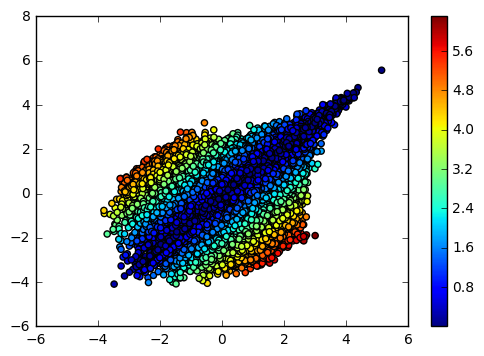

('HepG2', 'minP')
[[ 1.0000036   0.32542667]
 [ 0.32542667  1.0000036 ]]


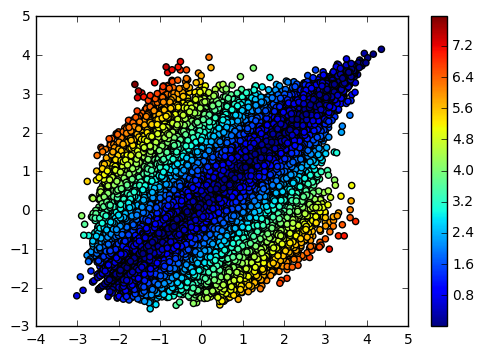

('K562', 'minP')
[[ 1.0000036   0.36576822]
 [ 0.36576822  1.0000036 ]]


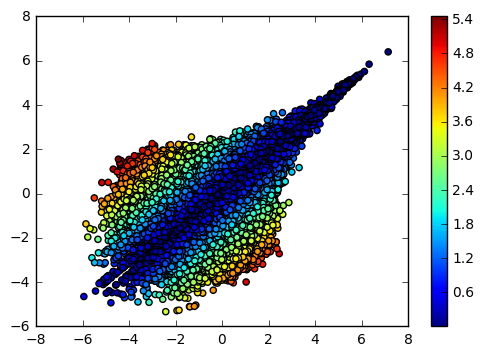

('HepG2', 'SV40P')
[[ 1.0000036   0.45198875]
 [ 0.45198875  1.0000036 ]]


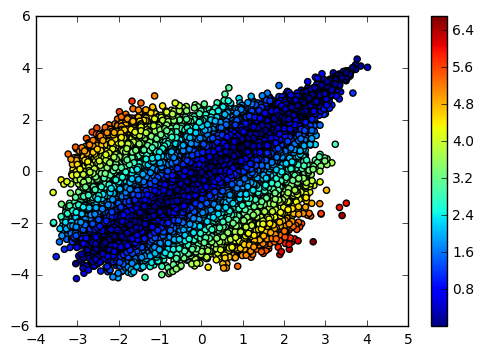

('K562', 'SV40P')
[[ 1.0000036   0.46768978]
 [ 0.46768978  1.0000036 ]]


In [16]:
 from sklearn.preprocessing import scale

#  Variance between replicates
 for experiment_key, key_to_normalized in split_data.items():
     vals = np.array([scale([key_to_normalized[key][0] for key in valid_keys]),
                  scale([key_to_normalized[key][1] for key in valid_keys])])
     w = np.array([sample_weights[experiment_key][key] for key in valid_keys])
     sc = plt.scatter(vals[0, :], vals[1, :], c=w)
     plt.colorbar(sc)
     plt.show()
     print experiment_key
     print np.cov(vals)

In [17]:
def kmerize(seq, k):
    """
    Returns np.array of kmer counts corresponding to given seq
    """
    bases = {'A': '00', 'C': '01', 'G': '10', 'T': '11'}
    binary_seq = ''.join([bases[char] for char in seq])
    counts = np.zeros((4**k,))
    for i in range(0, len(seq) - k + 1):
        counts[int(''.join(binary_seq[i*2:(i+k)*2]), 2)] += 1
    return counts

In [18]:
from sklearn.linear_model import SGDRegressor
sgd_models = []
for task in range(y.shape[1]):
    sgd_models += [SGDRegressor().fit(X_train, y_train[:, task], sample_weight = weights_train)]

In [26]:
def print_errors(models):
    for task, model in enumerate(models):
        mse =  sum([(i-j) **2 * k for i, j, k in zip(model.predict(X_valid), y_valid[:, task], weights_valid)]) / sum(weights_valid)
        print mse
        
def plot_predictions(models):
    for task, model in enumerate(models):
        plt.scatter(model.predict(X_valid), y_valid[:, task], s=.05)
        plt.show()

0.0283443975127
0.0525842016797
0.01708260736
0.0501954705143


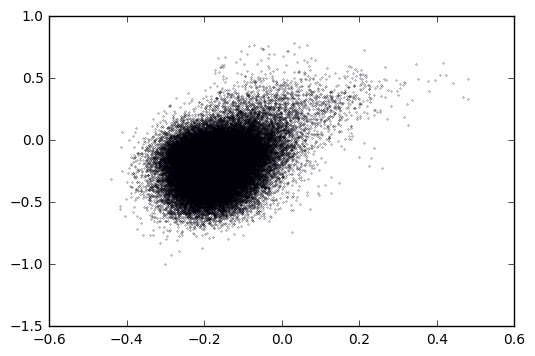

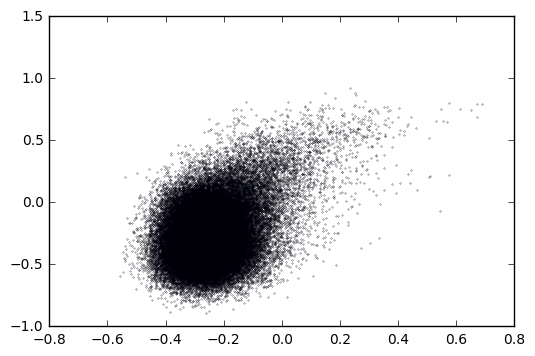

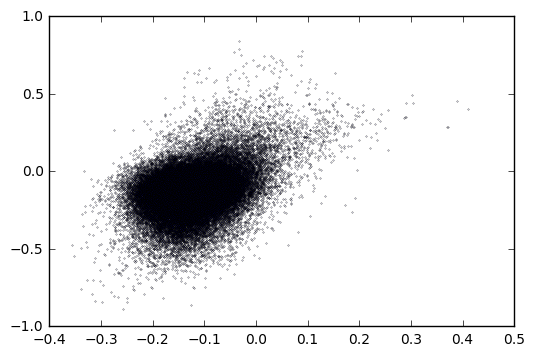

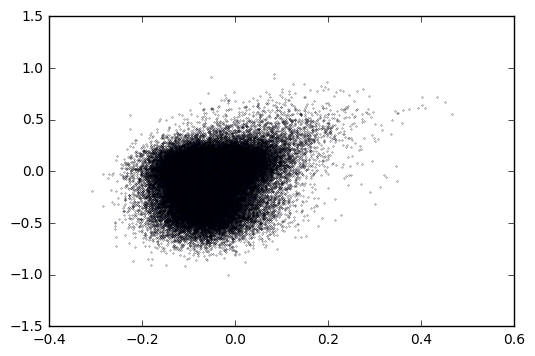

In [27]:
print_errors(sgd_models)
plot_predictions(sgd_models)